# Word2Vec - Word Embeddings

In [2]:
import sys
import os
import pandas as pd

# Agregar el directorio raiz al PYTHONPATH
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
# Cargar datos
from constants.constants_twitter import TWITTER_DATASET_TRAIN_PATH

df = pd.read_csv(TWITTER_DATASET_TRAIN_PATH)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59476 entries, 0 to 59475
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  59476 non-null  int64 
 1   text      59476 non-null  object
dtypes: int64(1), object(1)
memory usage: 929.4+ KB
None


## Generar embeddings

In [66]:
from src.preprocesamiento.nlp_spacy import Tokenizer

docs = Tokenizer().tokenize(df['text'], True)

Modelo cargado: es_core_news_sm


100%|██████████| 59476/59476 [01:10<00:00, 847.65it/s] 


In [115]:
DIM_EMBEDDINGS = 100
SG = 1
EPOCHS = 20

In [116]:
# Tokenizar el texto
import gensim
from constants.constants_twitter import EMBEDDING_W2V_TWITTER_PATH

print("Entrenando modelo de W2V...")
model = gensim.models.Word2Vec(
    sentences=docs,
    vector_size=DIM_EMBEDDINGS,
    epochs=EPOCHS,
    seed=42,
    sg=SG # skipgram or cbow
)

# Guardar modelo
model.save(f"{EMBEDDING_W2V_TWITTER_PATH}.model")
# Guardar VEctores de palabras (no entrenables)
model.wv.save_word2vec_format(f"{EMBEDDING_W2V_TWITTER_PATH}.bin", binary=True)

print(f"Modelo guardado en {EMBEDDING_W2V_TWITTER_PATH}.model")
print(f"Word Vectors guardados en {EMBEDDING_W2V_TWITTER_PATH}.bin")

Entrenando modelo de W2V...
Modelo guardado en c:\Users\Diego\Desktop\sentiment_analysis\models\twitter\embeddings\w2v_embeddings_twitter.model
Word Vectors guardados en c:\Users\Diego\Desktop\sentiment_analysis\models\twitter\embeddings\w2v_embeddings_twitter.bin


## Test

In [4]:
from src.trainers.utils import EmbeddingLoader
from constants.constants_twitter import EMBEDDING_W2V_TWITTER_PATH

path = f"{EMBEDDING_W2V_TWITTER_PATH}.bin"
embedding_loader = EmbeddingLoader(path)
word_vectors = embedding_loader.get_word_vectors()

print(f" Tamaño de embeddings: {word_vectors.vector_size}")
print(f" Tamaño del vocabulario: {len(word_vectors)}")

 Tamaño de embeddings: 100
 Tamaño del vocabulario: 8976


In [118]:
display(word_vectors.most_similar("sad"))
display(word_vectors.most_similar("awesom"))
display(word_vectors.most_similar("boy"))
display(word_vectors.most_similar("girl"))

[('cicada', 0.6064507365226746),
 ('tortur', 0.5851126909255981),
 ('512', 0.5589835047721863),
 ('unsurpris', 0.5421980023384094),
 ('kansa', 0.5418751835823059),
 ('vlad', 0.5266799330711365),
 ('stem', 0.5260409712791443),
 ('jealousi', 0.5151247382164001),
 ('drinker', 0.5140380263328552),
 ('hungri', 0.5110512971878052)]

[('great', 0.5623499751091003),
 ('good', 0.5381404757499695),
 ('firestorm', 0.5069651007652283),
 ('mc', 0.49959951639175415),
 ('fantast', 0.49834054708480835),
 ('sweepstak', 0.49530643224716187),
 ('amaz', 0.49021223187446594),
 ('catkin', 0.4833611249923706),
 ('ky', 0.4830045700073242),
 ('oblivi', 0.4686632752418518)]

[('gecko', 0.6329536437988281),
 ('anglo', 0.6280715465545654),
 ('shorti', 0.6182814836502075),
 ('quack', 0.5520625710487366),
 ('awsomusprimeog', 0.5450665354728699),
 ('outing', 0.5351754426956177),
 ('fre', 0.5342496037483215),
 ('perri', 0.5323512554168701),
 ('powerpoint', 0.5228153467178345),
 ('accuraci', 0.5212364196777344)]

[('minerva', 0.5660244226455688),
 ('paranoid', 0.5621021389961243),
 ('salti', 0.5474346280097961),
 ('front', 0.5367043614387512),
 ('newborn', 0.5264706015586853),
 ('vhnmxpgoou', 0.5241407155990601),
 ('pretend', 0.5174515843391418),
 ('sister', 0.5111622214317322),
 ('shi', 0.510818600654602),
 ('tia', 0.5107330083847046)]

## ¿Cuanto espacio ocupa en RAM el modelo?

In [119]:
import numpy as np

vocab_size = len(word_vectors.index_to_key)
embedding_dim = word_vectors.vector_size

print(f" Tamaño del vocabulario: {vocab_size}")
print(f" Tamaño de los embeddings: {embedding_dim}")
print(f" Tipo de dato de los embeddings: {word_vectors.vectors.dtype}")

bytes_per_number = np.dtype(np.float32).itemsize  # 4 bytes por número
total_bytes = vocab_size * embedding_dim * bytes_per_number
total_mb = total_bytes / (1024 ** 2)  # Convertir a MB

print(f"El modelo ocupa aproximadamente: {total_mb:.2f} MB en RAM")

 Tamaño del vocabulario: 8976
 Tamaño de los embeddings: 100
 Tipo de dato de los embeddings: float32
El modelo ocupa aproximadamente: 3.42 MB en RAM


## ¿Cuánto espacio ocupan los embeddings de cada token del dataset de Twitter?

In [120]:
total_memory = 0

for doc in docs:
    embeddings = [embedding_loader.get_embedding(token) for token in doc]
    memory_per_text = len(embeddings) * word_vectors.vector_size * 4 / (1024)
    total_memory += memory_per_text

print(f"Memoria total ocupada por los embeddings: {total_memory:.2f} KB -> {total_memory/(1024**2):.2f} GB")


Memoria total ocupada por los embeddings: 265058.98 KB -> 0.25 GB


## Graficar algunos embeddings

In [121]:
from sklearn.decomposition import PCA
import numpy as np
import plotly.express as px
import plotly.io as pio

bg_color="plotly_dark" # https://plotly.com/python/templates/
pio.templates.default = bg_color # Establecer el tema oscuro por defecto

words = list(word_vectors.index_to_key)[:300]
print(words)
embeddings = [embedding_loader.get_embedding(word) for word in words]
embeddings = np.array(embeddings)

# Reducir la dimensionalidad de los embeddings a 3D usando PCA
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings)

df_plot = pd.DataFrame(embeddings_3d, columns=["X", "Y", "Z"])
df_plot["word"] = words

# Graficar con Plotly
fig = px.scatter_3d(df_plot, x="X", y="Y", z="Z", text="word", title="Visualización 3D de Embeddings", width=800, height=800)
fig.update_traces(marker=dict(size=6), selector=dict(mode='markers+text'))  # Ajusta el tamaño de los puntos
fig.show()

['game', 's', 't', 'com', 'play', 'good', 'm', 'like', '2', 'fuck', 'pic', 'get', 'twitter', 'time', 'love', 'johnson', 'new', 'go', 'k', 'watch', '3', 'look', 'shit', 'thank', 'amazon', 'peopl', 'box', 'verizon', 'bad', 'day', 'year', 'great', 'microsoft', 'don', 'facebook', 'home', 'war', 'win', 'work', 'googl', 'red', 'dead', '1', 'nvidia', 'come', 'know', 'ps', 'want', 'chandler', 'fix', 'think', 'tri', '5', 'buy', 'tv', 'help', 'borderland', 'support', 'fife', 'wait', 'team', 'name', 'guy', 'news', 'depot', 'legend', 'fun', 'nba', 'pub', 'x', 'video', 'today', 'duti', '4', 'v', 'rainbow', 'denial', 'need', '2020', 'twitch', 'd', 'player', 'leagu', 'feel', 'world', 'thing', 'ghost', 'redempt', 'cs', 'man', 'say', 'hearthston', 'stream', 'live', 'apex', 'datum', 'updat', 'stop', 'ta', 'low', 'start', 'right', '10', 'seri', 'excit', 'amaz', 'big', 'u', 'craft', 'make', 'final', 'assassin', 'actual', 'damn', 'black', 'let', 'creed', 'kill', 'well', 'happi', 'youth', 'econ', 'server', 

['game', 's', 't', 'com', 'play', 'good', 'm', 'like', '2', 'fuck', 'pic', 'get', 'twitter', 'time', 'love', 'johnson', 'new', 'go', 'k', 'watch', '3', 'look', 'shit', 'thank', 'amazon', 'peopl', 'box', 'verizon', 'bad', 'day', 'year', 'great', 'microsoft', 'don', 'facebook', 'home', 'war', 'win', 'work', 'googl', 'red', 'dead', '1', 'nvidia', 'come', 'know', 'ps', 'want', 'chandler', 'fix', 'think', 'tri', '5', 'buy', 'tv', 'help', 'borderland', 'support', 'fife', 'wait', 'team', 'name', 'guy', 'news', 'depot', 'legend', 'fun', 'nba', 'pub', 'x', 'video', 'today', 'duti', '4', 'v', 'rainbow', 'denial', 'need', '2020', 'twitch', 'd', 'player', 'leagu', 'feel', 'world', 'thing', 'ghost', 'redempt', 'cs', 'man', 'say', 'hearthston', 'stream', 'live', 'apex', 'datum', 'updat', 'stop', 'ta', 'low', 'start', 'right', '10', 'seri', 'excit', 'amaz', 'big', 'u', 'craft', 'make', 'final', 'assassin', 'actual', 'damn', 'black', 'let', 'creed', 'kill', 'well', 'happi', 'youth', 'econ', 'server', 

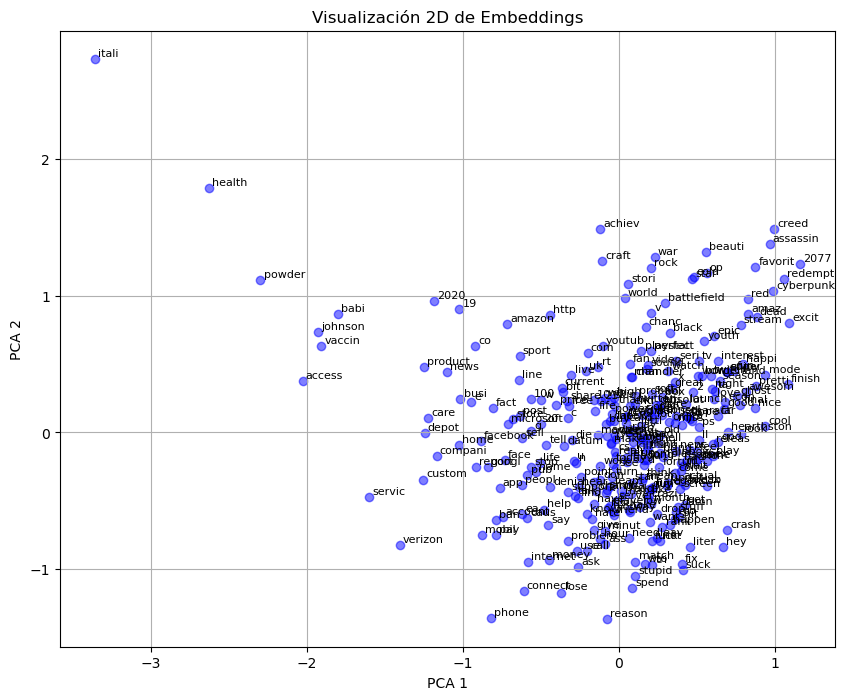

In [6]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

words = list(word_vectors.index_to_key)[:300]
print(words)
embeddings = [embedding_loader.get_embedding(word) for word in words]
embeddings = np.array(embeddings)

pca = PCA(n_components=2) # Reducción de embeddings a 2 dimensiones
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))

for i in range(len(embeddings_2d)):
    x, y_ = embeddings_2d[i]
    plt.scatter(x, y_, color='blue', alpha=0.5)
    plt.text(x + 0.02, y_ + 0.02, str(words[i]), fontsize=8)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualización 2D de Embeddings')
plt.grid(True)
plt.show()